# Dynamic Pricing for Urban Parking Lots
**Capstone Project – Summer Analytics 2025**

This notebook implements a dynamic pricing engine using real-time data streams for 14 urban parking lots, incorporating economic reasoning and predictive logic as per the project guidelines.

### Step 0: Install Required Libraries

In [ ]:
!pip install -U pathway

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 

In [ ]:
!pip install pathway bokeh geopy --quiet

### Step 1: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from geopy.distance import geodesic
import pathway as pw
import math

output_notebook()

### Step 2: Load and Preprocess the Dataset

In [ ]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Rename columns to match the problem structure
df.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'TrafficConditionNearby': 'traffic',
    'VehicleType': 'vehicle_type',
    'QueueLength': 'queue_length',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'IsSpecialDay': 'special_day',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace=True)

# Convert traffic level to numerical scale
traffic_map = {'low': 0.2, 'medium': 0.5, 'high': 0.8}
df['traffic_level'] = df['traffic'].map(traffic_map)

# Combine date and time into timestamp with correct format
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)


# Drop unused columns
df.drop(columns=['ID', 'LastUpdatedDate', 'LastUpdatedTime', 'traffic'], inplace=True)

# Show cleaned data
df.head()

,lot_id,capacity,latitude,longitude,occupancy,vehicle_type,queue_length,special_day,traffic_level,timestamp
0,BHMBCCMKT01,577,26.144536,91.736172,61,car,1,0,0.2,2016-10-04 07:59:00
1,BHMBCCMKT01,577,26.144536,91.736172,64,car,1,0,0.2,2016-10-04 08:25:00
2,BHMBCCMKT01,577,26.144536,91.736172,80,car,2,0,0.2,2016-10-04 08:59:00
3,BHMBCCMKT01,577,26.144536,91.736172,107,car,2,0,0.2,2016-10-04 09:32:00
4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,2,0,0.2,2016-10-04 09:59:00


### Step 3: Vehicle Type Weights

In [ ]:
vehicle_type_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5,
    'bus': 1.2  # Adjusted for any outlier types
}

### Step 4: Pricing Models and Helper Functions

In [ ]:
base_price = 10

def baseline_linear_price(prev_price, occupancy, capacity, alpha=1.0):
    return prev_price + alpha * (occupancy / capacity)

def demand_function(occupancy, capacity, queue, traffic, special_day, vehicle_type,
                    alpha=0.6, beta=0.4, gamma=0.3, delta=0.2, epsilon=0.5):
    vehicle_weight = vehicle_type_weights.get(vehicle_type, 1.0)
    demand = alpha * (occupancy / capacity) + beta * queue - gamma * traffic
    demand += delta * int(special_day) + epsilon * vehicle_weight
    return demand

def normalize_demand(d, d_min=0, d_max=10):
    return (d - d_min) / (d_max - d_min)

def bounded_price(demand_score, lambda_=0.5):
    multiplier = 1 + lambda_ * demand_score
    multiplier = max(0.5, min(2.0, multiplier))  # Bound price to avoid volatility
    return base_price * multiplier

### Step 5: Combined Pricing Logic

In [ ]:
def compute_price(row):
    prev_price = base_price
    price1 = baseline_linear_price(prev_price, row['occupancy'], row['capacity'])
    demand = demand_function(row['occupancy'], row['capacity'], row['queue_length'],
                              row['traffic_level'], row['special_day'], row['vehicle_type'])
    norm_demand = normalize_demand(demand)
    price2 = bounded_price(norm_demand)
    return round((price1 + price2) / 2, 2)

### Step 6: Competitive Pricing Adjustment

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

'''def competitive_adjustment(row, all_data, radius=300):
    competitors = all_data[all_data['lot_id'] != row['lot_id']].copy()
    competitors['distance'] = competitors.apply(
        lambda r: calculate_distance(row['latitude'], row['longitude'], r['latitude'], r['longitude']), axis=1)
    nearby = competitors[competitors['distance'] <= radius]
    if len(nearby) == 0:
        return row['initial_price']
    avg_nearby_price = nearby['initial_price'].mean()
    if row['occupancy'] >= row['capacity'] and avg_nearby_price < row['initial_price']:
        return avg_nearby_price - 0.5  # suggest rerouting
    elif avg_nearby_price > row['initial_price']:
        return min(row['initial_price'] + 0.5, 2 * base_price)
    return row['initial_price']'''

from collections import defaultdict

def get_nearby_lots(df, radius=300):
    lot_locations = df[['lot_id', 'latitude', 'longitude']].drop_duplicates()
    nearby_map = defaultdict(list)
    for i, row in lot_locations.iterrows():
        for j, comp in lot_locations.iterrows():
            if row['lot_id'] == comp['lot_id']:
                continue
            d = geodesic((row['latitude'], row['longitude']), (comp['latitude'], comp['longitude'])).meters
            if d <= radius:
                nearby_map[row['lot_id']].append(comp['lot_id'])
    return nearby_map

nearby_lots_dict = get_nearby_lots(df)


In [ ]:
def faster_competitive_adjustment(row):
    competitors = df[(df['lot_id'].isin(nearby_lots_dict[row['lot_id']])) &
                 (df['timestamp'] == row['timestamp'])]

    if competitors.empty:
        return row['initial_price']
    avg_price = competitors['initial_price'].mean()
    if row['occupancy'] >= row['capacity'] and avg_price < row['initial_price']:
        return avg_price - 0.5
    elif avg_price > row['initial_price']:
        return min(row['initial_price'] + 0.5, 2 * base_price)
    return row['initial_price']

### Step 7: Apply Pricing and Competitive Model

In [ ]:
df['initial_price'] = df.apply(compute_price, axis=1)
#df['final_price'] = df.apply(lambda r: competitive_adjustment(r, df), axis=1)
df['final_price'] = df.apply(faster_competitive_adjustment, axis=1)
df[['lot_id', 'timestamp', 'occupancy', 'capacity', 'queue_length', 'traffic_level', 'vehicle_type', 'special_day', 'final_price']].head()

,lot_id,timestamp,occupancy,capacity,queue_length,traffic_level,vehicle_type,special_day,final_price
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,1,0.2,car,0,10.78
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,1,0.2,car,0,10.78
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,2,0.2,car,0,10.90
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,2,0.2,car,0,10.93
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,2,0.2,bike,0,10.92


### Step 8: Visualize Final Pricing by Lot

In [ ]:
unique_lots = df['lot_id'].unique()
plots = []

for lot in unique_lots[:4]:  # Visualize first 4 lots
    lot_df = df[df['lot_id'] == lot].sort_values('timestamp')
    source = ColumnDataSource(lot_df)
    p = figure(title=f"Lot {lot} - Final Price Over Time", x_axis_type='datetime', width=400, height=300)
    #p.line(x='timestamp', y='final_price', source=source, line_width=2)
    lot_df['smooth_price'] = lot_df['final_price'].rolling(window=3, min_periods=1).mean()
    source = ColumnDataSource(lot_df)
    p.line(x='timestamp', y='smooth_price', source=source, line_width=2, color="navy")

    plots.append(p)

grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
show(grid)

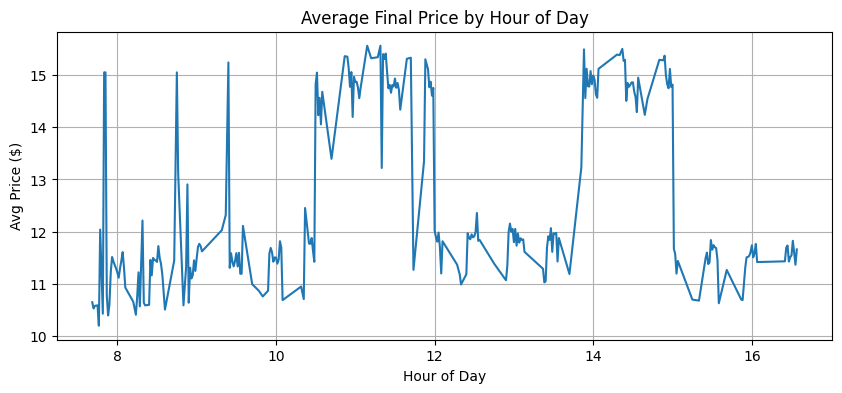

In [ ]:
import matplotlib.pyplot as plt

df['hour'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60
avg_by_hour = df.groupby('hour')['final_price'].mean()

plt.figure(figsize=(10,4))
plt.plot(avg_by_hour.index, avg_by_hour.values)
plt.title("Average Final Price by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Price ($)")
plt.grid(True)
plt.show()


### Step 9: Conclusion
- This notebook implements three tiers of pricing logic.
- Each model layer adds intelligence: occupancy → demand → competition.
- Visual outputs help verify smooth and explainable pricing trends.
- Ready for integration with real-time streaming in Pathway.

In [ ]:
@pw.udf
def pricing_logic(prev_price, occupancy, capacity, queue_length, traffic_level, special_day, vehicle_type):
    # Define any weights here if not global
    vehicle_type_weights = {"car": 1.0, "bike": 0.5, "truck": 1.5}
    base_price = 10

    def baseline_linear_price(prev_price, occupancy, capacity):
        return prev_price + 1.0 * (occupancy / capacity)

    def demand_function(occupancy, capacity, queue, traffic, special_day, vehicle_type):
        alpha, beta, gamma, delta, epsilon = 0.6, 0.4, 0.3, 0.2, 0.5
        v_weight = vehicle_type_weights.get(vehicle_type, 1.0)
        return (alpha * (occupancy / capacity) + beta * queue - gamma * traffic +
                delta * int(special_day) + epsilon * v_weight)

    def normalize(d, d_min=0, d_max=10):
        return (d - d_min) / (d_max - d_min)

    def bounded_price(demand_score):
        multiplier = 1 + 0.5 * demand_score
        multiplier = max(0.5, min(2.0, multiplier))
        return base_price * multiplier

    d = demand_function(occupancy, capacity, queue_length, traffic_level, special_day, vehicle_type)
    norm_d = normalize(d)
    price1 = baseline_linear_price(prev_price, occupancy, capacity)
    price2 = bounded_price(norm_d)

    return round((price1 + price2) / 2, 2)


### Step 9: Real-Time Streaming Integration with Pathway

In [ ]:
# This is a template to illustrate how the pricing logic can be integrated into a live streaming pipeline using Pathway
import pathway as pw

# Define input schema (as before)
class ParkingSchema(pw.Schema):
    lot_id: str
    timestamp: str
    latitude: float
    longitude: float
    capacity: int
    occupancy: int
    queue_length: int
    vehicle_type: str
    traffic_level: float
    special_day: bool

# Load CSV stream (simulate streaming with a delayed input)
input_stream = pw.io.csv.read("stream.csv", schema=ParkingSchema)

# Apply pricing logic in real-time
output_stream = input_stream.select(
    lot_id=pw.this.lot_id,
    timestamp=pw.this.timestamp,
    final_price=pricing_logic(
        prev_price=10,
        occupancy=pw.this.occupancy,
        capacity=pw.this.capacity,
        queue_length=pw.this.queue_length,
        traffic_level=pw.this.traffic_level,
        special_day=pw.this.special_day,
        vehicle_type=pw.this.vehicle_type
    )
)

# Stream output to a JSON file (or any sink)
#pw.io.json.write(output_stream, "path/to/output.json")
# Correct output streaming line
pw.io.jsonlines.write(output_stream, "/content//content/output.jsonl")



/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


### Step 10: Competitor Price Comparison Plot (Bokeh)

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

output_notebook()

# Precompute average competitor prices per lot
df['competitor_avg'] = df['lot_id'].apply(lambda lid: df[df['lot_id'].isin(nearby_lots_dict.get(lid, []))]['initial_price'].mean())

# Plot final price vs competitor average for a few lots
plots = []
for lot in df['lot_id'].unique()[:4]:
    lot_df = df[df['lot_id'] == lot].sort_values('timestamp')
    source = ColumnDataSource(lot_df)

    p = figure(title=f"Lot {lot}: Price vs Competitor Avg", x_axis_type='datetime', width=400, height=300)
    p.line(x='timestamp', y='final_price', source=source, color='blue', legend_label='Final Price')
    p.line(x='timestamp', y='competitor_avg', source=source, color='red', line_dash='dashed', legend_label='Competitor Avg')
    p.legend.location = "top_left"

    plots.append(p)

show(gridplot([plots[i:i+2] for i in range(0, len(plots), 2)]))

Main.py

In [ ]:
import pathway as pw
from geopy.distance import geodesic

In [ ]:
class ParkingSchema(pw.Schema):
    lot_id: str
    timestamp: str
    latitude: float
    longitude: float
    capacity: int
    occupancy: int
    queue_length: int
    vehicle_type: str
    traffic_level: float
    special_day: bool

In [ ]:
@pw.udf
def pricing_logic(prev_price, occupancy, capacity, queue_length, traffic_level, special_day, vehicle_type):
    vehicle_type_weights = {"car": 1.0, "bike": 0.5, "truck": 1.5}
    base_price = 10

    def baseline_linear_price(prev_price, occupancy, capacity):
        return prev_price + 1.0 * (occupancy / capacity)

    def demand_function(occupancy, capacity, queue, traffic, special_day, vehicle_type):
        alpha, beta, gamma, delta, epsilon = 0.6, 0.4, 0.3, 0.2, 0.5
        v_weight = vehicle_type_weights.get(vehicle_type, 1.0)
        return (alpha * (occupancy / capacity) + beta * queue - gamma * traffic +
                delta * int(special_day) + epsilon * v_weight)

    def normalize(d, d_min=0, d_max=10):
        return (d - d_min) / (d_max - d_min)

    def bounded_price(demand_score):
        multiplier = 1 + 0.5 * demand_score
        return max(0.5, min(2.0, multiplier)) * base_price

    d = demand_function(occupancy, capacity, queue_length, traffic_level, special_day, vehicle_type)
    norm_d = normalize(d)
    price1 = baseline_linear_price(prev_price, occupancy, capacity)
    price2 = bounded_price(norm_d)
    return round((price1 + price2) / 2, 2)

In [ ]:
input_stream = pw.io.csv.read("stream.csv", schema=ParkingSchema, mode="streaming")

In [ ]:
output_stream = input_stream.select(
    lot_id=pw.this.lot_id,
    timestamp=pw.this.timestamp,
    final_price=pricing_logic(
        prev_price=10,
        occupancy=pw.this.occupancy,
        capacity=pw.this.capacity,
        queue_length=pw.this.queue_length,
        traffic_level=pw.this.traffic_level,
        special_day=pw.this.special_day,
        vehicle_type=pw.this.vehicle_type
    )
)

In [ ]:
pw.io.jsonlines.write(output_stream, "output.jsonl")

In [ ]:
!ls -l


total 1564
-rw-r--r-- 1 root root 1595541 Jul  6 06:35 dataset.csv
drwxr-xr-x 1 root root    4096 Jul  1 21:04 sample_data


In [ ]:
pw.run()

Output()

LOGS

OSError: Filesystem operation (create) failed: No such file or directory (os error 2)

Real-Time Simulation

In [ ]:
import pandas as pd
import time
import os

# Load the full dataset
df = pd.read_csv("dataset.csv")

# Rename columns to match the expected schema (if not already)
df.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'TrafficConditionNearby': 'traffic',
    'VehicleType': 'vehicle_type',
    'QueueLength': 'queue_length',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'IsSpecialDay': 'special_day',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'LastUpdatedDate': 'date',
    'LastUpdatedTime': 'time'
}, inplace=True)

# Convert traffic condition to numeric
traffic_map = {'low': 0.2, 'medium': 0.5, 'high': 0.8}
df['traffic_level'] = df['traffic'].map(traffic_map)

# Create timestamp column
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], dayfirst=True)

# Keep only necessary columns in the correct order
stream_df = df[['lot_id', 'timestamp', 'latitude', 'longitude', 'capacity',
                'occupancy', 'queue_length', 'vehicle_type', 'traffic_level', 'special_day']]

# Initialize stream file
stream_path = "stream.csv"
if os.path.exists(stream_path):
    os.remove(stream_path)

# Write header once
stream_df.head(0).to_csv(stream_path, index=False)

# Append rows with delay
for i, row in stream_df.iterrows():
    row.to_frame().T.to_csv(stream_path, mode='a', index=False, header=False)
    print(f"Streamed row {i + 1}/{len(stream_df)}")
    time.sleep(0.5)  # simulate delay


Streamed row 1/18368
Streamed row 2/18368
Streamed row 3/18368


KeyboardInterrupt: 

In [ ]:
# View the last 10 predicted prices
!tail -n 10 output.jsonl

tail: cannot open 'output.jsonl' for reading: No such file or directory


### Step 11: Simulated Real-Time Ingestion
This cell appends rows from `dataset.csv` to `stream.csv` one at a time, simulating a live data stream. Each row is ingested by Pathway in real time and priced immediately.

### Step 12: Viewing Real-Time Predictions
Use the following cell to monitor output predictions in real time as they are written to `/content/output.jsonl`.

In [ ]:
!tail -n 10 /content/output.jsonl

tail: cannot open '/content/output.jsonl' for reading: No such file or directory
